In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 64kB/s 
     |████████████████████████████████| 204kB 43.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=0e25687070a56c095bcccd8dd561473d12cf45a61b3bab4797d0652cd4f412e5
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 35.8 MB of archives.
After this operation, 140 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# whole data
#id='12PGUriSWBVqOUabywZCc2kiwQVaHHXni'
#downloaded = drive.CreateFile({'id': id}) 
#downloaded.GetContentFile('consolidated_tweets_df.csv')

#id='1J0sccQPs28-h0OYPi2fR9ubuqxubN7hs'
#downloaded = drive.CreateFile({'id': id}) 
#downloaded.GetContentFile('consolidated_retweets_df.csv') 

In [0]:
id='1QmKZzdrnNfSZ0RWrW89d6V_SG8cp03AK'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('consolidated_tweets_df.csv')

id='1_pp8dvoiEjWRRAu48KwcSYBsTcLKywUU'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('consolidated_retweets_df.csv') 

In [0]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [5]:
import networkx as nx
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [7]:
spark

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-06-05 04:42:36--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.6.123.150, 34.204.135.175, 52.5.95.18, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.6.123.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.4MB/s    in 0.4s    

2020-06-05 04:42:37 (37.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://a593e6e04a7a.ngrok.io


In [0]:
#user_tweets = pd.read_csv("consolidated_user.csv", lineterminator='\n', dtype = {"tweet_id": str, "user_id": str})
#user_tweets = user_tweets.drop(columns = ['Unnamed: 0', "Unnamed: 0.1"])
#print(user_tweets.shape)
#user_tweets.head()

In [0]:
user_schema = StructType([
    StructField("tweet_id", StringType()),
    StructField("user_id", StringType()),
    StructField("user_name", StringType()),
    StructField("user_location", StringType()),
    StructField("user_follower_count", DoubleType()),
    StructField("user_friend_count", DoubleType()),
    StructField("user_favorite_count", DoubleType()),
    StructField("user_statuses_count", DoubleType()),
])

#user_df = spark.createDataFrame(user_tweets, schema=user_schema)

In [12]:
tweets_data = pd.read_csv("consolidated_tweets_df.csv", lineterminator='\n', dtype = {"tweet_id": object, "article_id": object, "tweet_created_at": str, "user_id" : str}, parse_dates = ['tweet_created_at'])
tweets_data = tweets_data.drop(columns = ["Unnamed: 0", 'test'])
print(tweets_data.shape)
tweets_data.head()

(213823, 6)


,article_id,tweet_id,tweet_created_at,retweet_count,user_id,cold_user
0,politifact13013,771487002575286273,2016-09-01 23:16:49+00:00,0,313584104,1
1,politifact13013,771271973229826048,2016-09-01 09:02:22+00:00,0,10480592,1
2,politifact13013,771288677557280768,2016-09-01 10:08:45+00:00,0,175844074,1
3,politifact13013,771223329214566400,2016-09-01 05:49:04+00:00,0,2577100238,1
4,politifact13013,771475597918740481,2016-09-01 22:31:30+00:00,0,453088398,1


In [0]:
tweet_schema = StructType([
    StructField("article_id", StringType()),
    StructField("tweet_id", StringType()),
    StructField("tweet_created_at", DateType()),
    StructField("retweet_count", StringType()),
    StructField("user_id", StringType()),
    StructField("cold_user", IntegerType())
])

tweets_df = spark.createDataFrame(tweets_data, schema=tweet_schema)
tweets_df = tweets_df.distinct()
tweets_df = tweets_df.groupBy("tweet_id", "tweet_created_at", "user_id").agg(max("retweet_count").alias("retweet_count"))

In [16]:
retweets_data = pd.read_csv("consolidated_retweets_df.csv", dtype={"tweet_id": str, "retweet_id" : str, "retweet_created_at":str, "retweet_user_id": str}, parse_dates=['retweet_created_at'])
retweets_data = retweets_data.drop(columns=['Unnamed: 0', 'test'])
print(retweets_data.shape)
retweets_data.head()

(32646, 8)


,article_id,tweet_id,retweet_id,retweet_count,retweet_created_at,retweet_user_id,is_quote_status,cold_user
0,politifact13013,771417626513772544,771420531291787264,1,2016-09-01 18:52:41+00:00,49053573,0.0,0
1,politifact13013,771130571489550336,771130907533139973,1,2016-08-31 23:41:49+00:00,2935416411,0.0,1
2,politifact13013,773849741524344832,773871933574279168,1,2016-09-08 13:13:41+00:00,862238221,0.0,1
3,politifact13013,771316782934155264,771585933787340800,1,2016-09-02 05:49:56+00:00,318417786,0.0,1
4,politifact13013,771078878529892353,771079225751339009,1,2016-08-31 20:16:28+00:00,2611772656,0.0,1


In [0]:
retweets_schema = StructType([
      StructField("article_id", StringType()),
      StructField("tweet_id", StringType()),
      StructField("retweet_id", StringType()),
      StructField("retweet_count", LongType()),
      StructField("retweet_created_at", DateType()),
      StructField("retweet_user_id", StringType()),
      StructField("is_quote_status", DoubleType()),
      StructField("cold_user", IntegerType())                   
])

retweets_df = spark.createDataFrame(retweets_data, schema=retweets_schema)
retweets_df = retweets_df.drop("article_id").distinct()

In [0]:
temp_tweets_df = tweets_df.join(retweets_df.select("tweet_id", col("retweet_count").alias("retweet_count2")).distinct(), "tweet_id", how="left")
temp_tweets_df = temp_tweets_df.groupBy('tweet_id', 'tweet_created_at', 'user_id', 'retweet_count').agg(max("retweet_count2").alias("retweet_count2"))

In [0]:
tweets_df = temp_tweets_df.withColumn("max_retweet_count", when(col("retweet_count") > col("retweet_count2"), 
                                                                col("retweet_count")).otherwise(col("retweet_count2"))).select("tweet_id", "tweet_created_at", 
                                                                "user_id", col("max_retweet_count").alias("retweet_count"))

In [0]:
all_tweet_retweet_count = tweets_df.select("tweet_id", "user_id", "retweet_count").distinct().union(retweets_df.select(col("retweet_id").alias("tweet_id"), 
                                                                                                            col("retweet_user_id").alias("user_id"), col("retweet_count"))).distinct()

In [0]:
user_tweet_weights = all_tweet_retweet_count.select("user_id", "tweet_id", when(col("retweet_count") == 0, 0.0).otherwise(1.0/col("retweet_count")).alias("weight"))
user_weights = user_tweet_weights.groupBy("user_id").agg(sum("weight").alias("weight"), collect_list("tweet_id").alias("tweet_ids"), count("*").alias("count"))
user_weights_list = user_weights.rdd.map(lambda row: row.asDict()).collect()
user_weights_dict = {user['user_id']: user for user in user_weights_list}

In [0]:
retweeters_list = tweets_df.select("user_id", "tweet_id").join(retweets_df, "tweet_id").select("tweet_id", "user_id", "retweet_user_id", 
                                                                                          "retweet_count").groupBy("tweet_id", "user_id", 
                                                                                          "retweet_count").agg(collect_list("retweet_user_id").alias("retweet_user_ids"))\
                                                                                          .rdd.map(lambda row: row.asDict()).collect()
retweeters_dict = {tweet['tweet_id']: tweet for tweet in retweeters_list}

In [23]:
len(retweeters_dict)

3779

In [0]:
for tweetId in retweeters_dict:
  retweeters_dict[tweetId]['retweet_user_ids'].append(retweeters_dict[tweetId]['user_id'])

In [0]:
#create links
user_link_tweets = {}
for tweetId in retweeters_dict:
  retweet_count = retweeters_dict[tweetId]['retweet_count']
  retweet_weight = (0 if retweet_count == 0 else 1.0/float(retweet_count))
  for user1 in set(retweeters_dict[tweetId]['retweet_user_ids']):
    for user2 in set(retweeters_dict[tweetId]['retweet_user_ids']):
      if user1 != user2:
        if (user1, user2) in user_link_tweets:
          user_link_tweets[(user1, user2)][tweetId] = retweet_weight
        else:
          user_link_tweets[(user1, user2)]= {tweetId: retweet_weight}

In [0]:
user_links = {}
for user_pair in user_link_tweets:
  user_links[user_pair] = {'value': np.sum(list(user_link_tweets[user_pair].values()))}
  user_links[user_pair]['number_tweets'] = len(user_link_tweets[user_pair])

In [27]:
print(len(user_link_tweets))
print(len(user_links))

1265898
1265898


In [0]:
def calculate_cosine(entry):
  user1 = entry[0]
  user2 = entry[1]
  user1_weight = user_weights_dict[user1]['weight']
  user2_weight = user_weights_dict[user2]['weight']
  if (user1_weight == 0 or user2_weight == 0):
    print(user1, user2)
  value = float(user_links[entry]["value"])/user1_weight/user2_weight
  return value

In [0]:
user_similarity = {}
for entry in user_links:
  user_similarity[entry] = calculate_cosine(entry)

In [31]:
nodes = {}
ids = {}
i = 0
for user in user_weights_dict:
    #nodes[i] ={"name": user_weights_dict[user]["user_name"], "value": user_weights_dict[user]["count"]}
    nodes[i] ={"value": user_weights_dict[user]["count"]}
    #ids.append(user)
    ids[user] = i
    i += 1
print("number of nodes: ", len(nodes))
#print(nodes)

number of nodes:  175378


In [0]:
node_userid_lookup = dict([(node, userid) for userid, node in ids.items()])

In [33]:
edges = {}
#i = 0
for link in user_similarity:
    if link[0] in ids and link[1] in ids:
        if ids[link[0]] < ids[link[1]]:
            edges[(ids[link[0]], ids[link[1]])] = {"weight": user_similarity[link], "number_tweets": user_links[link]["number_tweets"]}
print("number of edges: ", len(edges))

number of edges:  632949


In [0]:
edges_list = []
for edge in edges:
  edges_list.append([edge[0], edge[1], edges[edge]['weight']])

In [0]:
G = nx.Graph()
#G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges_list)

In [36]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 28026
Number of edges: 632949
Average degree:  45.1687


In [0]:
active_users = [node_userid_lookup[node] for node in G.nodes]

In [0]:
import community
parts = community.best_partition(G, random_state=123)

In [0]:
clusters = {}
for i in list(set(parts.values())):
  clusters[i] = []

for node in parts:
  clusters[parts[node]].append(node)

length_c = [len(clusters[c]) for c in clusters]

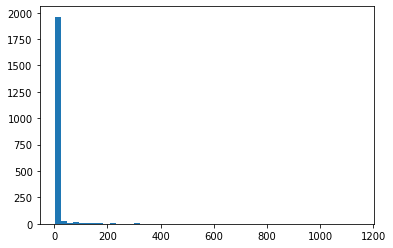

<BarContainer object of 2064 artists>

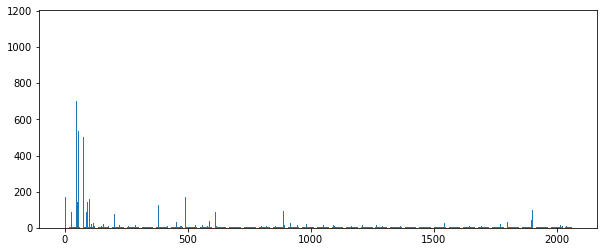

In [49]:
plt.hist(length_c, bins = 50)
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(list(clusters.keys()), length_c)

In [0]:
c_size = {}
for c in clusters:
  c_size[c] = len(clusters[c])

In [0]:
df = pd.DataFrame(list(c_size.items()), columns=['Cluster', 'Size'])
df = df.sort_values('Size', ascending=False)

In [50]:
len(clusters)

2064

In [60]:
np.quantile(list(c_size.values()), 0.95)

22.84999999999991

In [0]:
highly_active_clusters = df[df.Size >= 300]
med_active_clusters = df[(df.Size < 300) & (df.Size >= 100)]
low_active_clusters = df[(df.Size < 100)]
inactive_clusters = df[df.Size < 100]

#inactive_nodes = []
#for c in inactive_clusters.Cluster:
#  inactive_nodes = inactive_nodes + clusters[c]

#active_nodes = list(set(nodes) - set(inactive_nodes))
#print(len(nodes), len(inactive_nodes), len(active_nodes))

In [142]:
low_active_clusters.shape

(2011, 2)

In [0]:
highly_active_nodes = []
for c in highly_active_clusters.Cluster:
  highly_active_nodes = highly_active_nodes + clusters[c]

med_active_nodes = []
for c in med_active_clusters.Cluster:
  med_active_nodes = med_active_nodes + clusters[c]

low_active_nodes = []
for c in low_active_clusters.Cluster:
  low_active_nodes = low_active_nodes + clusters[c]

inactive_nodes = []
for c in inactive_clusters.Cluster:
  inactive_nodes = inactive_nodes + clusters[c]

In [76]:
print(G.number_of_nodes(), len(highly_active_nodes), len(med_active_nodes), len(low_active_nodes), len(inactive_nodes))

28026 13459 4775 9792 9792


In [0]:
G2 = G.subgraph(highly_active_nodes)
part2 = community.best_partition(G2, random_state=123)

clusters2 = {}
for i in list(set(part2.values())):
  clusters2[i] = []

for node in part2:
  clusters2[part2[node]].append(node)

length_c2 = [len(clusters2[c]) for c in clusters2]

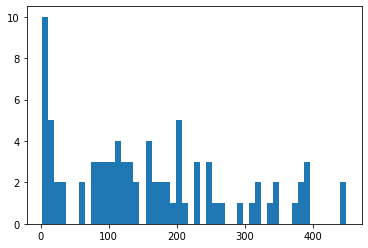

<BarContainer object of 85 artists>

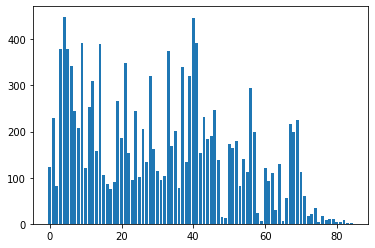

In [147]:
plt.hist(length_c2, bins = 50)
plt.show()
plt.bar(list(clusters2.keys()), length_c2)

In [0]:
G3 = G.subgraph(med_active_nodes)
part3 = community.best_partition(G3, random_state=123)

clusters3 = {}
for i in list(set(part3.values())):
  clusters3[i] = []

for node in part3:
  clusters3[part3[node]].append(node)

length_c3 = [len(clusters3[c]) for c in clusters3]

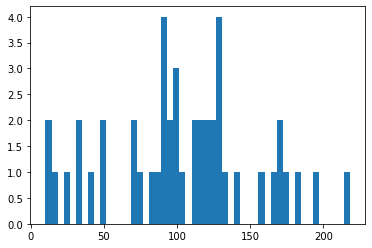

<BarContainer object of 46 artists>

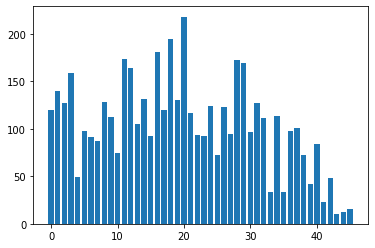

In [125]:
plt.hist(length_c3, bins = 50)
plt.show()
plt.bar(list(clusters3.keys()), length_c3)

In [0]:
G4 = G.subgraph(low_active_nodes)
part4 = community.best_partition(G4, random_state=123)

clusters4 = {}
for i in list(set(part4.values())):
  clusters4[i] = []

for node in part4:
  clusters4[part4[node]].append(node)

length_c4 = [len(clusters4[c]) for c in clusters4]

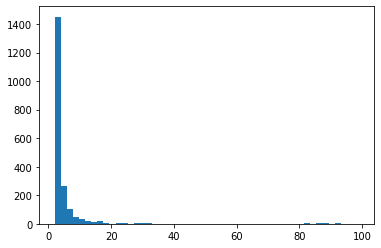

<BarContainer object of 2015 artists>

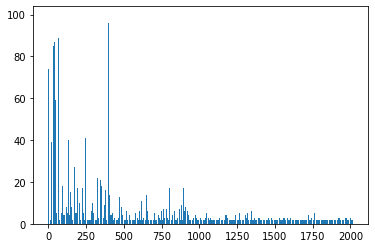

In [137]:
plt.hist(length_c4, bins = 50)
plt.show()
plt.bar(list(clusters4.keys()), length_c4)

In [138]:
print("2: ", community.modularity(part2, G2))
print("3: ", community.modularity(part3, G3))
print("4: ", community.modularity(part4, G4))

2:  0.9494115880678867
3:  0.935201573762257
4:  0.8603577507266477


In [127]:
print("1: ", community.modularity(parts, G))

1:  0.9431683584274398


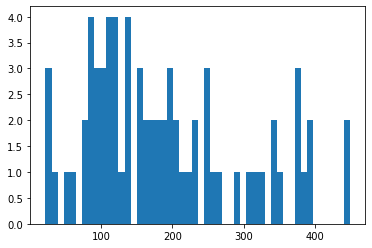

<BarContainer object of 71 artists>

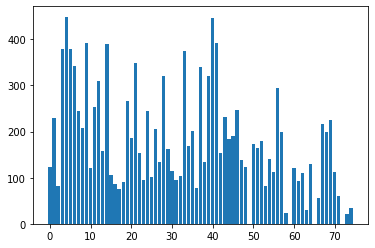

In [148]:
cluster2_small = [c for c in clusters2 if len(clusters2[c]) < 20]
clusters2_small_nodes = []
for c in cluster2_small:
  clusters2_small_nodes = clusters2_small_nodes + clusters2[c]

for c in cluster2_small:
  del clusters2[c]

clusters2[cluster2_small[0]] = clusters2_small_nodes
length_c2 = [len(clusters2[c]) for c in clusters2]

plt.hist(length_c2, bins = 50)
plt.show()
plt.bar(list(clusters2.keys()), length_c2)

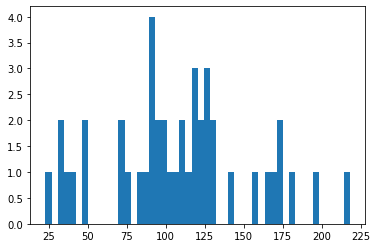

<BarContainer object of 44 artists>

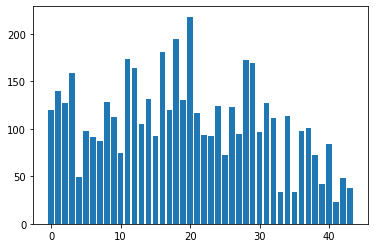

In [129]:
cluster3_small = [c for c in clusters3 if len(clusters3[c]) < 20]
clusters3_small_nodes = []
for c in cluster3_small:
  clusters3_small_nodes = clusters3_small_nodes + clusters3[c]

for c in cluster3_small:
  del clusters3[c]

clusters3[cluster3_small[0]] = clusters3_small_nodes
length_c3 = [len(clusters3[c]) for c in clusters3]

plt.hist(length_c3, bins = 50)
plt.show()
plt.bar(list(clusters3.keys()), length_c3)

In [0]:
#cluster4_small = [c for c in clusters4 if len(clusters4[c]) < 3]
#clusters4_small_nodes = []
#for c in cluster4_small:
#  clusters4_small_nodes = clusters4_small_nodes + clusters4[c]

#for c in cluster4_small:
#  del clusters4[c]

#clusters4[cluster4_small[0]] = clusters4_small_nodes
#length_c4 = [len(clusters4[c]) for c in clusters4]

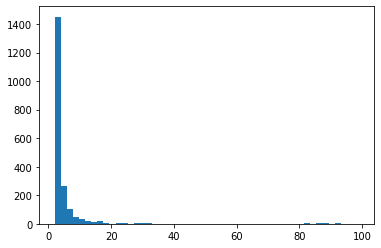

<BarContainer object of 2015 artists>

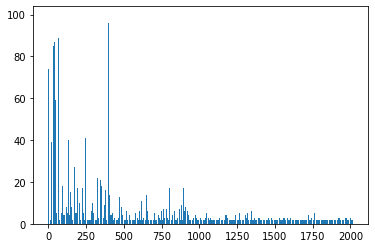

In [140]:
#plt.hist(length_c4, bins = 50)
#plt.show()
#plt.bar(list(clusters4.keys()), length_c4)

In [0]:
with open('all_user_ids.txt', 'w') as f:
    for userid in user_weights_dict:
        f.write("%s\n" % userid)

In [0]:
with open('active_user_ids.txt', 'w') as f:
    for userid in active_users:
        f.write("%s\n" % userid)

In [0]:
cluster_num = 0
final_partition = {}
for c in clusters2:
  for node in clusters2[c]:
    final_partition[node] = cluster_num
  cluster_num += 1

for c in clusters3:
  for node in clusters3[c]:
    final_partition[node] = cluster_num
  cluster_num += 1

for c in clusters4:
  for node in clusters4[c]:
    if node in final_partition:
      print(node)
    final_partition[node] = cluster_num
  cluster_num += 1

In [152]:
print(cluster_num)

2130


In [153]:
print(len(final_partition), len(parts))

28026 28026


In [154]:
connected_components = nx.connected_components(G)
connected_comp_length = []
for comp in connected_components:
  connected_comp_length.append(len(comp))

np.max(connected_comp_length)

19643

In [157]:
np.sort(connected_comp_length)

array([    2,     2,     2, ...,    99,   141, 19643])

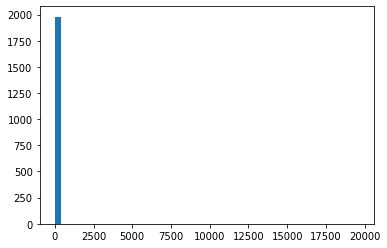

<BarContainer object of 1980 artists>

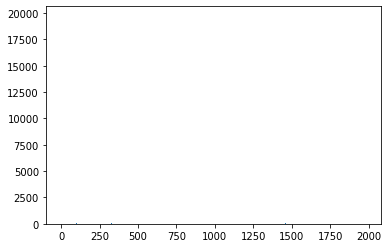

In [158]:
plt.hist(connected_comp_length, bins = 50)
plt.show()
plt.bar(range(len(connected_comp_length)), connected_comp_length)

In [159]:
len(connected_comp_length)

1980

In [0]:
connected_components = nx.connected_components(G)
comp_num=0
default_components = {}
for comp in connected_components:
  for node in comp:
    default_components[node_userid_lookup[node]] = comp_num
  comp_num +=1

(pd.DataFrame(list(default_components.items()), columns=['user_id', 'user_group']).to_csv('default_user_groups.csv', header=True, quoting= csv.QUOTE_NONNUMERIC))

In [0]:
user_group_mapping_louvain = {}
for node in final_partition:
  user_group_mapping_louvain[node_userid_lookup[node]] = final_partition[node]

(pd.DataFrame(list(user_group_mapping_louvain.items()), columns=['user_id', 'user_group']).to_csv('louvain_user_groups.csv', header=True, quoting= csv.QUOTE_NONNUMERIC))